In [1]:
# import the required libraries
import pandas as pd
import ydata_profiling as pdpf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("processed_maintenance_data.csv")

### MODELING

In [3]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import time

model_performance = pd.DataFrame(columns=['Accuracy', 'Precision',
                                          'Recall', 'F1-Score', 'Training time',
                                          'Prediction time'])

def log_scores(model_name, y_test, y_predictions):
    accuracy = accuracy_score(y_test, y_predictions)
    precision = precision_score(y_test, y_predictions, average='weighted')
    recall = recall_score(y_test, y_predictions, average='weighted')
    precision = precision_score(y_test, y_predictions, average='weighted')
    f1 = f1_score(y_test, y_predictions, average='weighted')

    # save the scores in model_performance dataframe
    model_performance.loc[model_name] = [accuracy, precision, recall, f1,
                                       end_train-start, end_predict-end_train]

### Data splitting and sampling

In [4]:
df.columns

Index(['Rotational speed', 'temperature_differential', 'thermal_stress',
       'Tool wear', 'Process temperature', 'Machine failure'],
      dtype='object')

In [39]:
df.describe()

,Rotational speed,temperature_differential,thermal_stress,Tool wear,Process temperature,Machine failure
count,16376.000000,16376.000000,16376.000000,16376.000000,16376.000000,16376.000000
mean,-0.484665,-0.503621,-0.071906,0.317299,0.184355,0.500000
std,1.033365,1.135802,0.951957,1.127098,0.888855,0.500015
min,-2.155044,-2.409576,-2.623263,-1.739094,-2.918856,0.000000
25%,-1.334288,-1.537390,-0.762000,-0.687970,-0.409581,0.000000
50%,-0.771756,-0.609112,-0.222602,0.435285,0.312794,0.500000
75%,0.213599,0.596800,0.531443,1.425114,0.786229,1.000000
max,2.790683,2.099989,3.000045,2.285129,2.574422,1.000000


70-30 dataset split (train, test)

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(["Machine failure"], axis=1)
y = df["Machine failure"]

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, 
                                                    random_state = 0,
                                                    stratify = y)

oversampling training set to overcome data imbalance

In [7]:
# from imblearn.over_sampling import SVMSMOTE
# from imblearn.over_sampling import RandomOverSampler

# oversample = SVMSMOTE(random_state = 42)
# #oversample = RandomOverSampler(random_state=42)

# X_train, y_train = oversample.fit_resample(X_train, y_train)

training set after oversampling

(array([5731.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5732.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

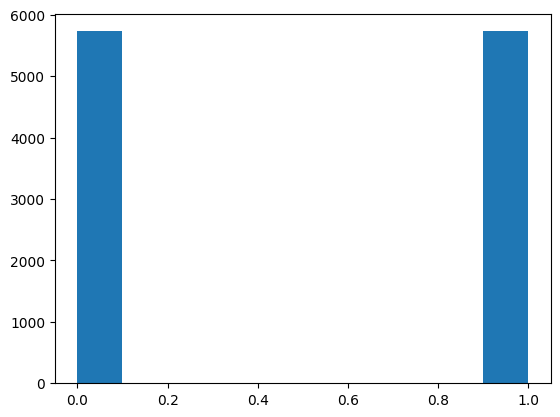

In [8]:
plt.hist(y_train)

### Decision Tree Model

In [9]:
from sklearn.tree import DecisionTreeClassifier

start = time.time()
model = DecisionTreeClassifier(max_depth = 8).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Decision Tree", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [10]:
print("Decision Tree\n" + classification_report(y_test, y_predictions))

Decision Tree
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      2457
         1.0       0.93      0.96      0.95      2456

    accuracy                           0.95      4913
   macro avg       0.95      0.95      0.95      4913
weighted avg       0.95      0.95      0.95      4913



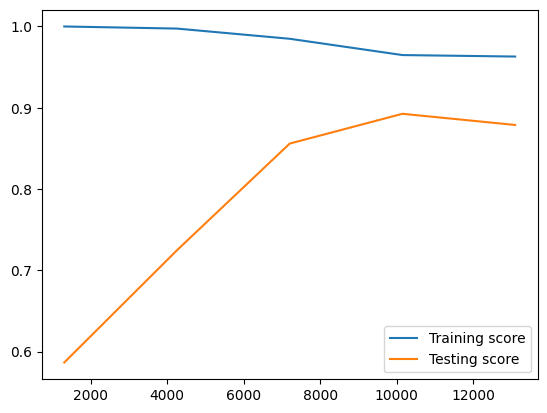

In [11]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of decision tree model

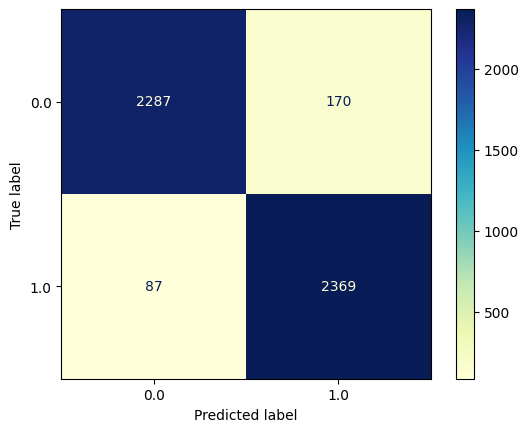

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

Graph

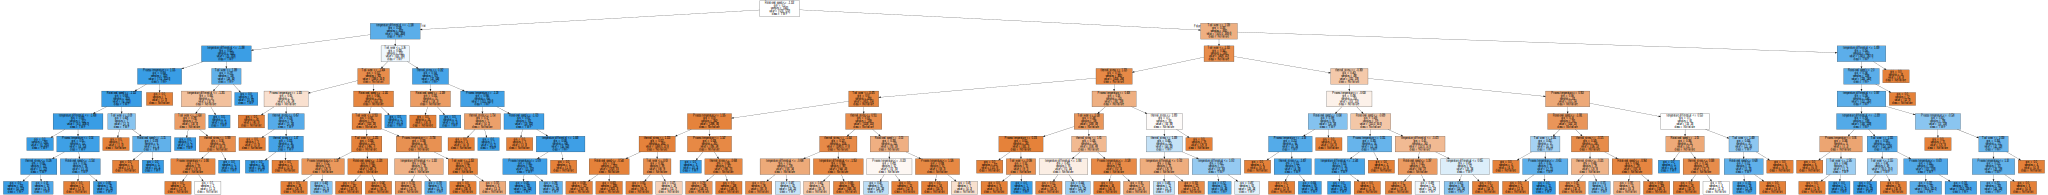

In [13]:
import graphviz
from sklearn import tree

data = tree.export_graphviz(model,
                            feature_names=X.columns,  
                            class_names=['No failure','TWF','HDF','PWF','OSF','RNF'],
                            filled=True)

# draw graph
graph = graphviz.Source(data, format="png") 
graph.render('nodes', view=False)
graph

In [14]:
from sklearn.tree import export_text

rules = export_text(model)

# print the rules
print(rules)

|--- feature_0 <= -1.13
|   |--- feature_1 <= -1.11
|   |   |--- feature_1 <= -1.31
|   |   |   |--- feature_4 <= 1.53
|   |   |   |   |--- feature_0 <= -1.15
|   |   |   |   |   |--- feature_1 <= -1.41
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- feature_1 >  -1.41
|   |   |   |   |   |   |--- feature_4 <= 0.54
|   |   |   |   |   |   |   |--- feature_2 <= 0.23
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- feature_2 >  0.23
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- feature_4 >  0.54
|   |   |   |   |   |   |   |--- feature_0 <= -1.51
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- feature_0 >  -1.51
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- feature_0 >  -1.15
|   |   |   |   |   |--- feature_3 <= 0.09
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_3 >  0.09
|   |   |   |   |   |   |--- feature_0 <= -1.15
|   |  

### k-NN (K-nearest neighbours) model

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# create the model
knn = KNeighborsClassifier()

# define the parameter grid
param_grid = {'n_neighbors': range(2, 20)}

# create the grid search object
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# print the best parameters
print(grid_search.best_params_)

{'n_neighbors': 2}


In [16]:
start = time.time()
model = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # predictions from the testset
end_predict = time.time()

# evaluate the model
log_scores("k-NN", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [17]:
print("k-NN Model\n" + classification_report(y_test, y_predictions))

k-NN Model
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      2457
         1.0       0.97      0.99      0.98      2456

    accuracy                           0.98      4913
   macro avg       0.98      0.98      0.98      4913
weighted avg       0.98      0.98      0.98      4913



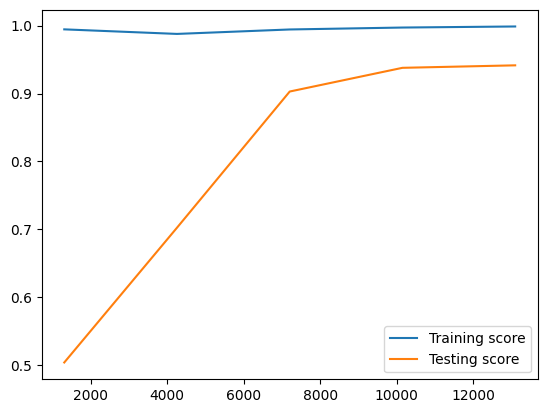

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix

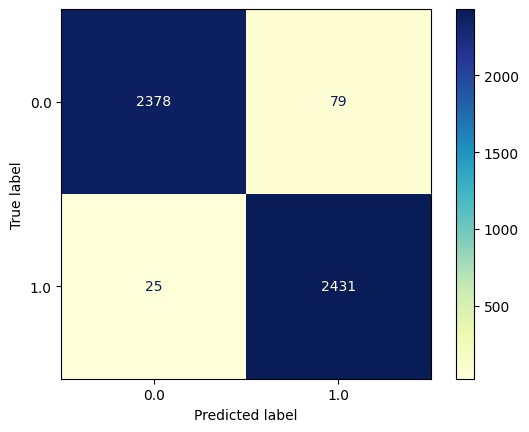

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Random forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()
model = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                               random_state=0, bootstrap=True).fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Random Forest", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [21]:
print("Random Forest Model\n" + classification_report(y_test, y_predictions))

Random Forest Model
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      2457
         1.0       0.97      0.98      0.98      2456

    accuracy                           0.98      4913
   macro avg       0.98      0.98      0.98      4913
weighted avg       0.98      0.98      0.98      4913



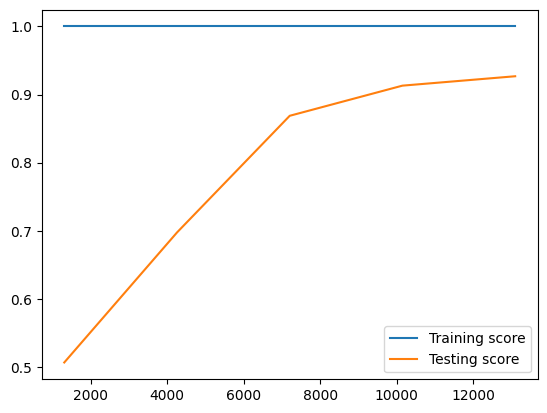

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Random Forest model

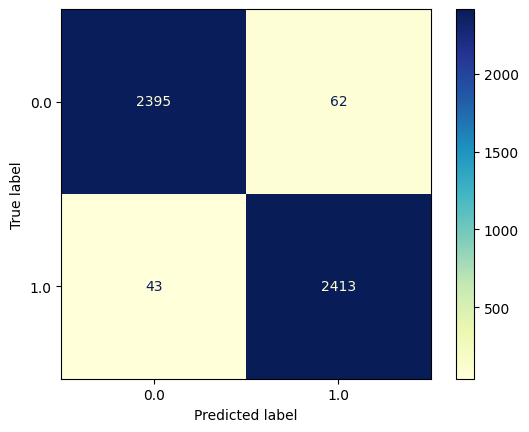

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Gradient Boosting Model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
model = GradientBoostingClassifier().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gradient Boosting", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [25]:
print("Gradient Boosting\n" + classification_report(y_test, y_predictions))

Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      2457
         1.0       0.95      0.94      0.94      2456

    accuracy                           0.94      4913
   macro avg       0.94      0.94      0.94      4913
weighted avg       0.94      0.94      0.94      4913



/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/ensemble/_gb.py"

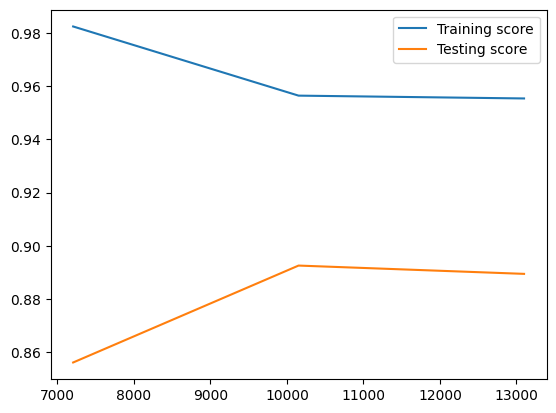

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Gradient Boosting model

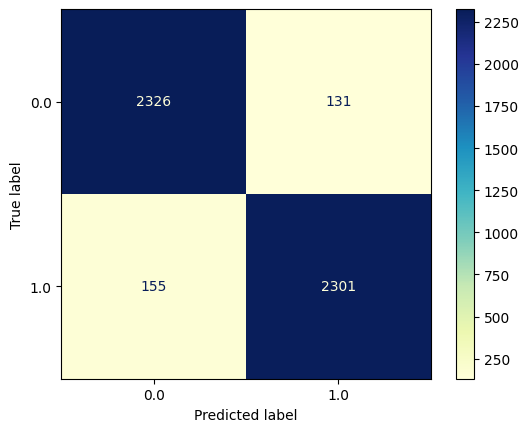

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Gaussian Naive Bayes Model

In [28]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
model = GaussianNB().fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Gaussian Naive Bayes", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [29]:
print("Gaussian Naive Bayes\n" + classification_report(y_test, y_predictions))

Gaussian Naive Bayes
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      2457
         1.0       0.78      0.78      0.78      2456

    accuracy                           0.78      4913
   macro avg       0.78      0.78      0.78      4913
weighted avg       0.78      0.78      0.78      4913



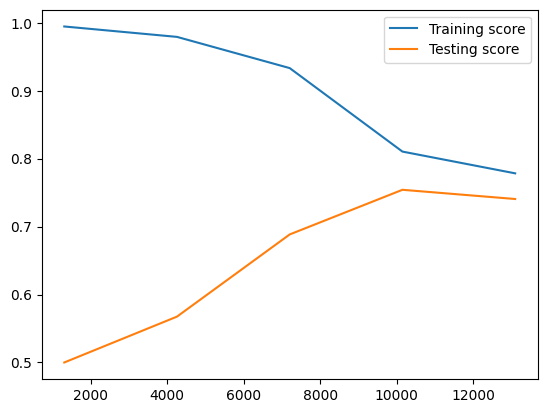

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

confusion matrix of Gaussian Naive Bayes model

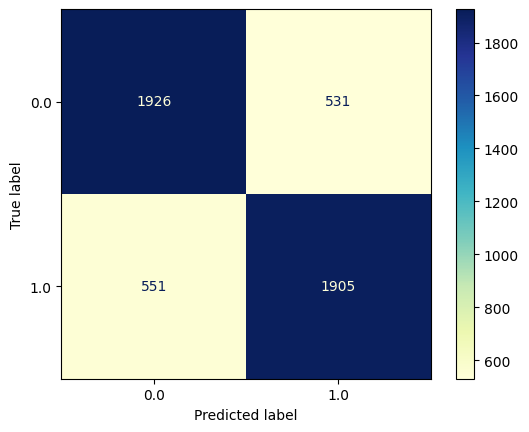

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### MLP (Multi-layer Perceptron) Model

In [32]:
from sklearn.neural_network import MLPClassifier

start = time.time()
model = MLPClassifier(random_state=1, max_iter=600, learning_rate="invscaling").fit(X_train, y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

# evaluate the model
log_scores("Multi-layer Perceptron", y_test, y_predictions)

Model evaluation:

- 0: No failure
- 1: Machine failure

In [33]:
print("Multi-layer Perceptron\n" + classification_report(y_test, y_predictions))

Multi-layer Perceptron
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      2457
         1.0       0.95      0.98      0.97      2456

    accuracy                           0.96      4913
   macro avg       0.97      0.96      0.96      4913
weighted avg       0.97      0.96      0.96      4913



/home/ubuntu/dev/Stats_analysis/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


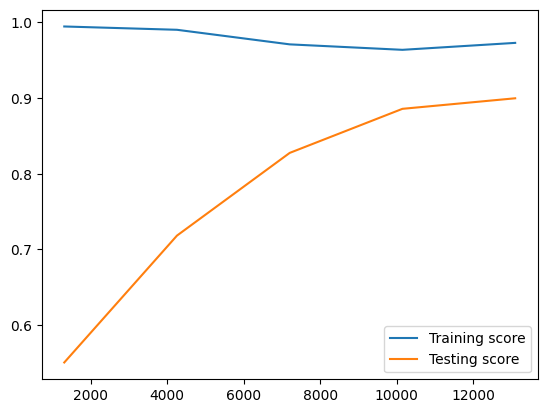

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

# plot the learning curve
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, test_scores .mean(axis=1), label='Testing score')
plt.legend(loc='best')
plt.show()

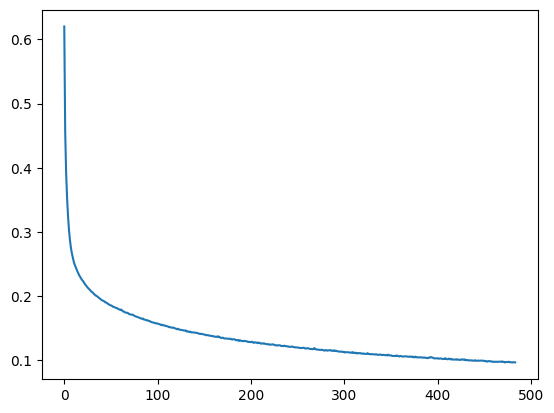

In [35]:
plt.plot(model.loss_curve_)

Confusion matrix of Multi-layer Perceptron model

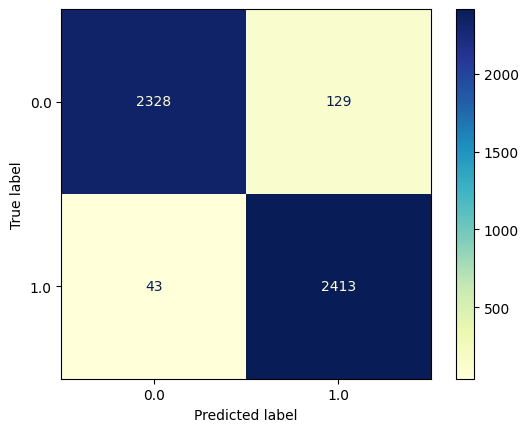

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, cmap=plt.cm.YlGnBu)  

### Evaluation

In [37]:
model_performance

,Accuracy,Precision,Recall,F1-Score,Training time,Prediction time
Decision Tree,0.947690,0.948202,0.947690,0.947675,0.033471,0.001324
k-NN,0.978832,0.979063,0.978832,0.978829,0.013037,0.263463
Random Forest,0.978628,0.978657,0.978628,0.978628,0.474863,0.061188
Gradient Boosting,0.941787,0.941829,0.941787,0.941786,1.587546,0.006259
Gaussian Naive Bayes,0.779768,0.779786,0.779768,0.779764,0.004530,0.002092
Multi-layer Perceptron,0.964991,0.965562,0.964991,0.964980,14.827096,0.015873


In [40]:
df.describe()

,Rotational speed,temperature_differential,thermal_stress,Tool wear,Process temperature,Machine failure
count,16376.000000,16376.000000,16376.000000,16376.000000,16376.000000,16376.000000
mean,-0.484665,-0.503621,-0.071906,0.317299,0.184355,0.500000
std,1.033365,1.135802,0.951957,1.127098,0.888855,0.500015
min,-2.155044,-2.409576,-2.623263,-1.739094,-2.918856,0.000000
25%,-1.334288,-1.537390,-0.762000,-0.687970,-0.409581,0.000000
50%,-0.771756,-0.609112,-0.222602,0.435285,0.312794,0.500000
75%,0.213599,0.596800,0.531443,1.425114,0.786229,1.000000
max,2.790683,2.099989,3.000045,2.285129,2.574422,1.000000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rotational speed          16376 non-null  float64
 1   temperature_differential  16376 non-null  float64
 2   thermal_stress            16376 non-null  float64
 3   Tool wear                 16376 non-null  float64
 4   Process temperature       16376 non-null  float64
 5   Machine failure           16376 non-null  float64
dtypes: float64(6)
memory usage: 767.8 KB
